In [1]:
from prompt_to_prompt.ptp_utils import init_latent, diffusion_step, register_attention_control, latent2image
from prompt_to_prompt.attention import AttentionStore
from prompt_to_prompt.visualise import view_images
from prompt_to_prompt.null_text_inversion import NullTextInversion

In [2]:
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler
from tqdm import tqdm

generator = torch.Generator().manual_seed(8888)
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
NUM_DIFFUSION_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
LOW_RESOURCE = False

In [4]:
model_path = "/vol/biomedic3/rrr2417/roentgen/roentgen"
ldm_stable = StableDiffusionPipeline.from_pretrained(model_path).to(torch.float32).to(device)
tokenizer = ldm_stable.tokenizer

/vol/biomedic3/rrr2417/cxr-generation/z/lib/python3.9/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [5]:
def run_and_display(diffuser, prompts, controller, latent=None, run_baseline=False, generator=None, uncond_embeddings=None, verbose=True):
    if run_baseline:
        print("w.o. prompt-to-prompt")
        images, latent = run_and_display(prompts, EmptyControl(), latent=latent, run_baseline=False, generator=generator)
        print("with prompt-to-prompt")
    images, x_t = text2image_ldm_stable(diffuser, prompts, controller, latent=latent, num_inference_steps=NUM_DIFFUSION_STEPS, guidance_scale=GUIDANCE_SCALE, generator=generator, uncond_embeddings=uncond_embeddings)
    if verbose:
        view_images(images)
    return images, x_t

In [6]:
@torch.no_grad()
def text2image_ldm_stable(
    model,
    prompt,
    controller,
    num_inference_steps,
    guidance_scale,
    generator = None,
    latent = None,
    uncond_embeddings = None,
    start_time = 50,
    return_type = 'image'
):
    batch_size = len(prompt)
    register_attention_control(model, controller)
    height = width = 512
    
    text_input = model.tokenizer(
        prompt,
        padding="max_length",
        max_length=model.tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )
    text_embeddings = model.text_encoder(text_input.input_ids.to(model.device))[0]
    max_length = text_input.input_ids.shape[-1]
    if uncond_embeddings is None:
        uncond_input = model.tokenizer(
            [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
        )
        uncond_embeddings_ = model.text_encoder(uncond_input.input_ids.to(model.device))[0]
    else:
        uncond_embeddings_ = None

    latent, latents = init_latent(latent, model, height, width, generator, batch_size)
    model.scheduler.set_timesteps(num_inference_steps)
    for i, t in enumerate(tqdm(model.scheduler.timesteps[-start_time:])):
        if uncond_embeddings_ is None:
            context = torch.cat([uncond_embeddings[i].expand(*text_embeddings.shape), text_embeddings])
        else:
            context = torch.cat([uncond_embeddings_, text_embeddings])
        latents = diffusion_step(model, controller, latents, context, t, guidance_scale, low_resource=False)
        
    if return_type == 'image':
        image = latent2image(model.vae, latents)
    else:
        image = latents
    return image, latent

In [7]:
nti = NullTextInversion(ldm_stable, NUM_DIFFUSION_STEPS, GUIDANCE_SCALE)

## Null-text Inversion

In [8]:
image_path = "p10_p10265727_s54247845.jpg"
prompt = "Normal chest radiograph. Specifically, no evidence of pneumonia."
(image_gt, image_enc), x_t, uncond_embeddings = nti.invert(image_path, prompt, offsets=(0, 0, 200, 0), verbose=True)

print("Modify or remove offsets according to your image!")

DDIM inversion...
Null-text optimization...


100%|███████████████████████████████████████████████████| 500/500 [01:29<00:00,  5.60it/s]

Modify or remove offsets according to your image!


100%|█████████████████████████████████████████████████████| 50/50 [00:04<00:00, 11.29it/s]


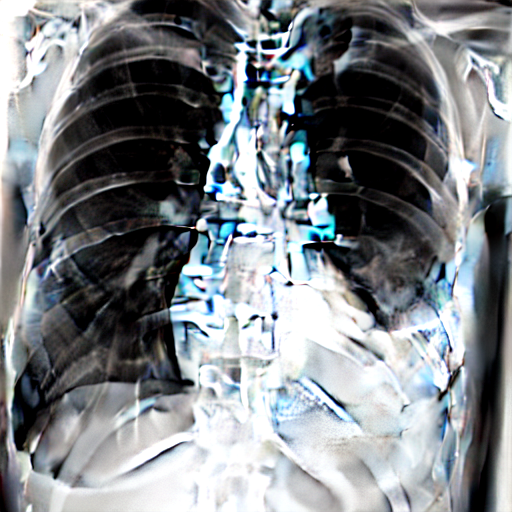

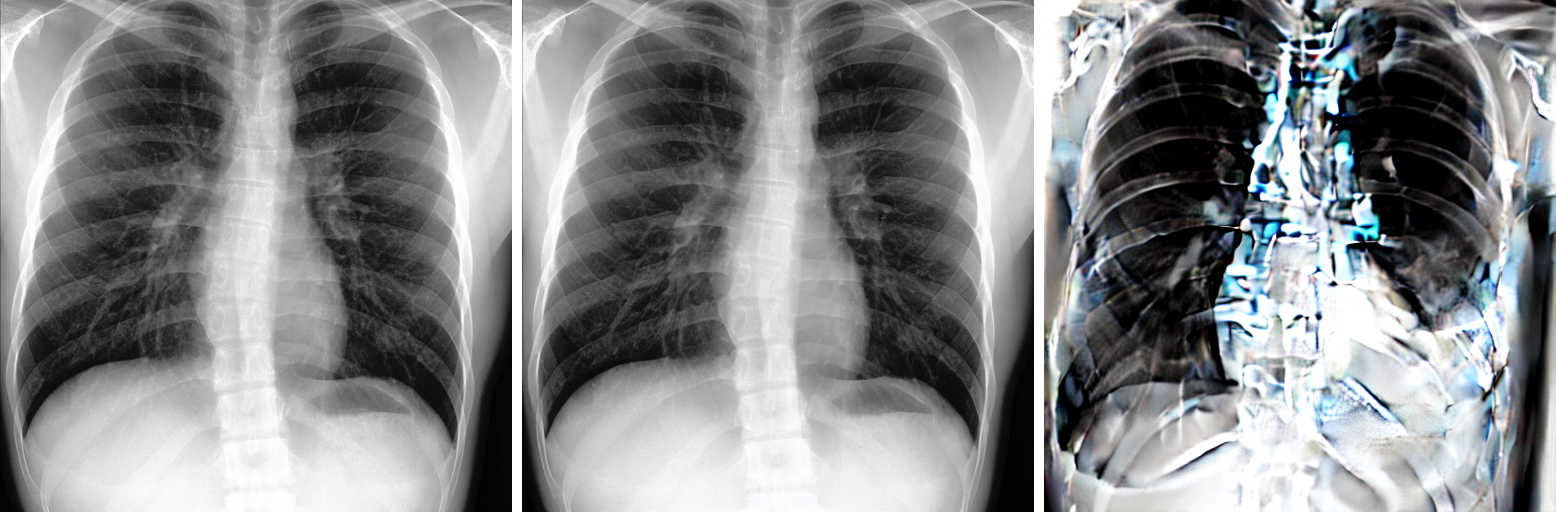

In [9]:
prompts = ["big left-sided pleural effusion"]
controller = AttentionStore(low_resource=LOW_RESOURCE)
image_inv, x_t = run_and_display(ldm_stable, prompts, controller, latent=x_t, uncond_embeddings=uncond_embeddings, run_baseline=False, generator=generator)
view_images([image_gt, image_enc, image_inv[0]])